960x540x1

META: Ticks per second: 7642

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 7

META: c_thresh_baseline: 5

META: c_thresh_max: 20

META: c_increase_velocity: 3


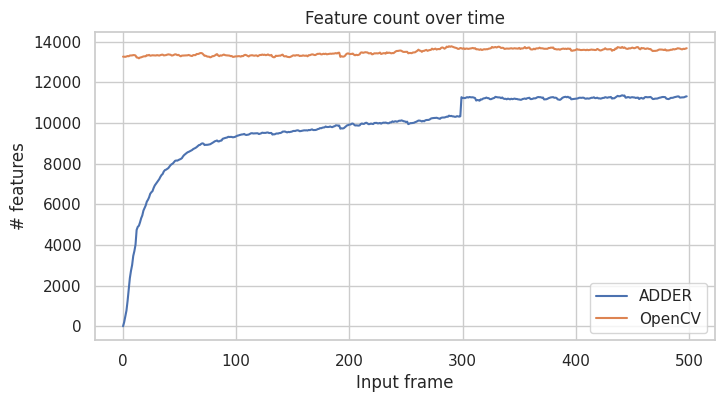

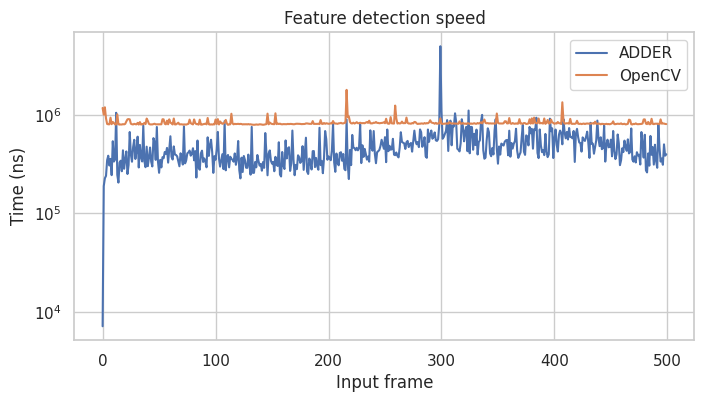

OpenCV mean: 829938.306   Median: 813888.0
ADDER mean: 475878.054 (-42.7%)   Median: 427632.0
739.381736755371 Mb
1977.5390625 Mb


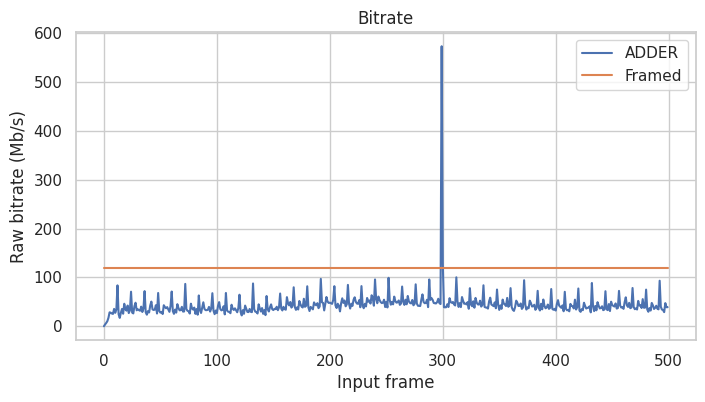

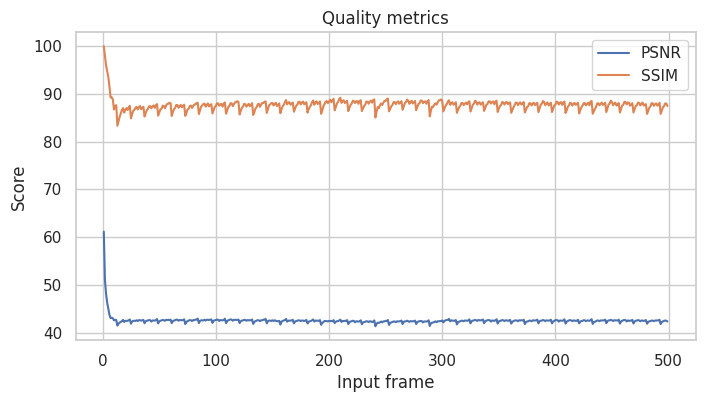

960x540x1

META: Ticks per second: 7642

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 7

META: c_thresh_baseline: 5

META: c_thresh_max: 20

META: c_increase_velocity: 3


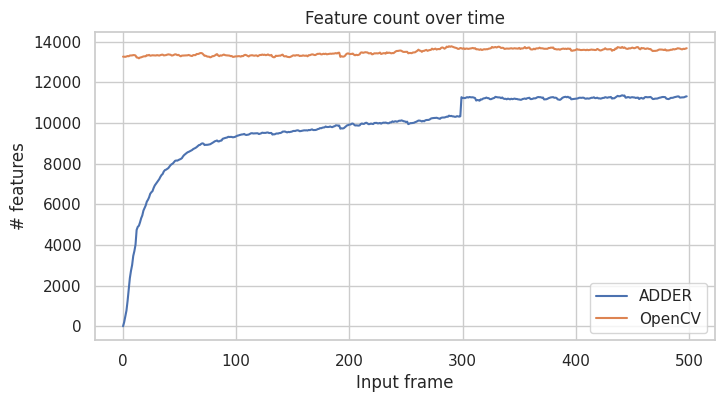

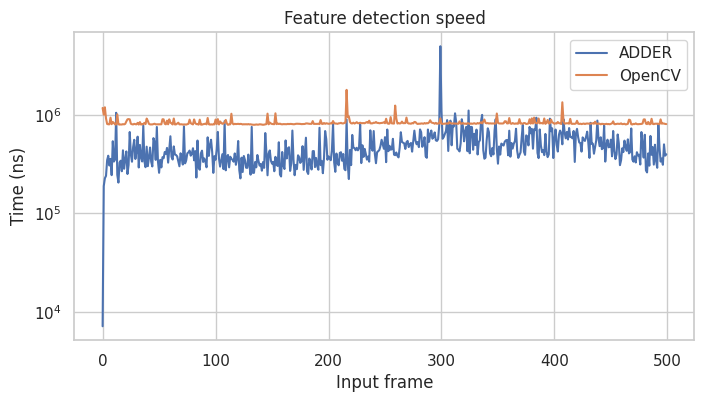

OpenCV mean: 829938.306   Median: 813888.0
ADDER mean: 475878.054 (-42.7%)   Median: 427632.0
739.381736755371 Mb
1977.5390625 Mb


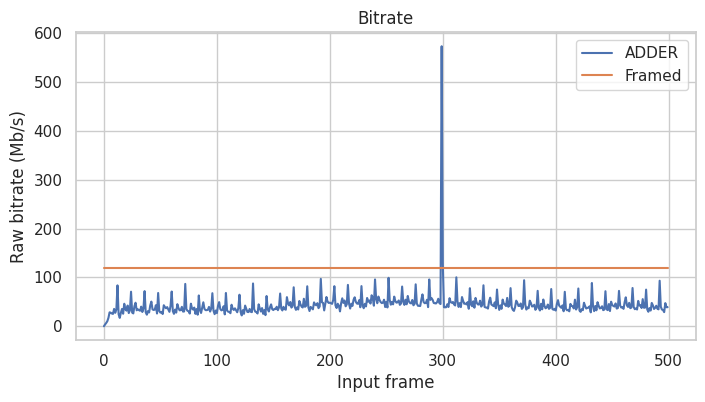

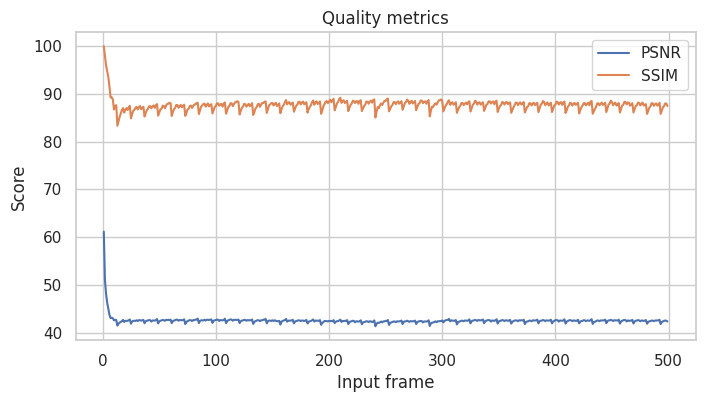

960x540x1

META: Ticks per second: 7642

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 7

META: c_thresh_baseline: 5

META: c_thresh_max: 20

META: c_increase_velocity: 3


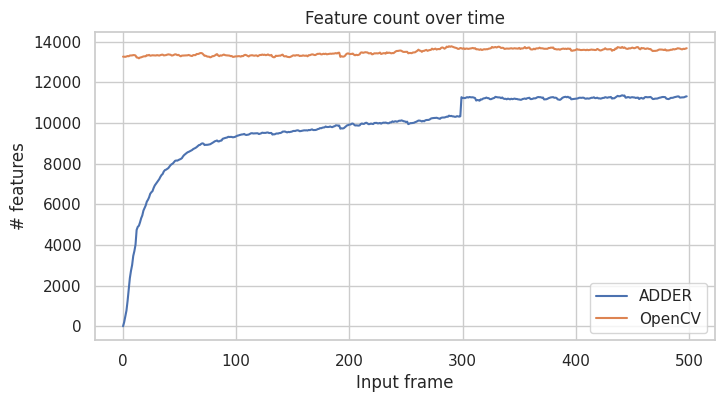

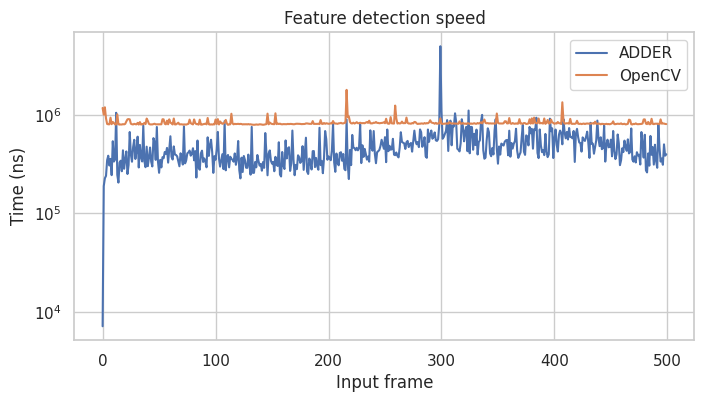

OpenCV mean: 829938.306   Median: 813888.0
ADDER mean: 475878.054 (-42.7%)   Median: 427632.0
739.381736755371 Mb
1977.5390625 Mb


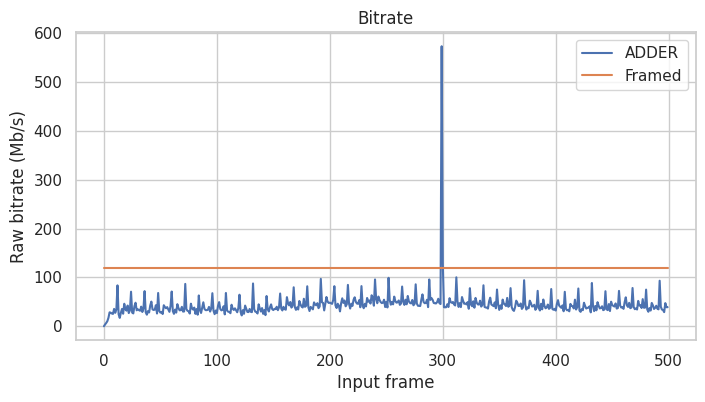

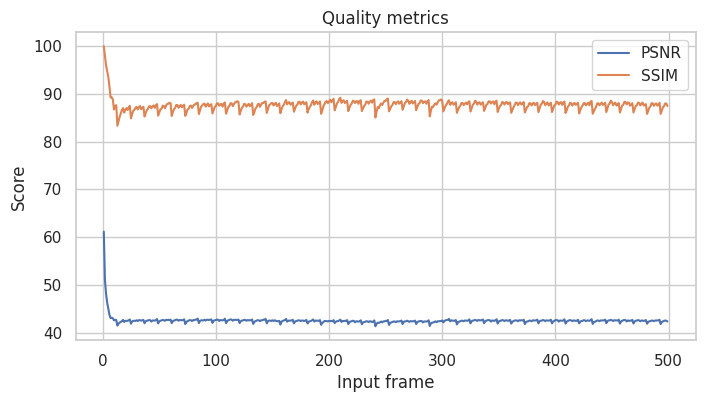

960x540x1

META: Ticks per second: 7642

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 7

META: c_thresh_baseline: 5

META: c_thresh_max: 20

META: c_increase_velocity: 3


KeyboardInterrupt: 

KeyboardInterrupt: 

In [2]:
# for i in range(4):
#     %run log_analyzer.ipynb

In [7]:
# Suppress cargo build warnings
%env RUSTFLAGS=-Awarnings
for i in range(10):
    print("Running CRF", i)
    ! cargo run --bin evaluate_feature_detection_transcode --release --features "open-cv feature-logging" -- --crf {i} --delta-t-max 76500 --frame-count-max 500 --input-filename "/media/andrew/ExternalM2/VIRAT/videos_original/VIRAT_S_040104_09_001475_001583.mp4" --scale 0.2 --detect-features


env: RUSTFLAGS=-Awarnings
Running CRF 0
    Finished release [optimized] target(s) in 0.17s
     Running `/home/andrew/Code/adder-codec-rs/target/release/evaluate_feature_detection_transcode --crf 0 --delta-t-max 76500 --frame-count-max 500 --input-filename /media/andrew/ExternalM2/VIRAT/videos_original/VIRAT_S_040104_09_001475_001583.mp4 --scale 0.2 --detect-features`
████████████████████████████████████████████████████████████████████████ 500/500

47260 ms elapsed


Running CRF 1
    Finished release [optimized] target(s) in 0.16s
     Running `/home/andrew/Code/adder-codec-rs/target/release/evaluate_feature_detection_transcode --crf 1 --delta-t-max 76500 --frame-count-max 500 --input-filename /media/andrew/ExternalM2/VIRAT/videos_original/VIRAT_S_040104_09_001475_001583.mp4 --scale 0.2 --detect-features`
████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 59/500^C
Running CRF 2


UnboundLocalError: local variable 'child' referenced before assignment